# Prepare tweets and news data for IBM topic
Last modifed: 2017-10-24

# Roadmap
1. Prepare multiprocessing and MongoDB scripts available in ibm_tweets_analysis project
2. Filter out tweets with keyword 'ibm' in tweet_text field from MongoDB db
3. Check basic statistics of embedded URL link in tweet_text to external news article
4. Manually collect external news articles
5. Check ibm_news basic statistics
6. Updated Objective: focus on "social_capital_ceo_palihapitiya_watson_joke" news and tweets

# Steps

In [1]:
"""
Initialization
"""

'''
Standard modules
'''
import os
import pickle
import csv
import time
from pprint import pprint
import json
import pymongo
import multiprocessing
import logging
import collections

'''
Analysis modules
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # render double resolution plot output for Retina screens 
import matplotlib.pyplot as plt
import pandas as pd


'''
Custom modules
'''
import config
import utilities
import mongodb
import multiprocessing_workers

'''
R magic and packages
'''
# hide all RRuntimeWarnings
import warnings
warnings.filterwarnings('ignore')

# add home for R in anaconda on PATH sys env
os.environ['PATH'] += ':/opt/anaconda3/bin'

# load R magic
%load_ext rpy2.ipython

# load R packages
%R require(ggplot2)

'''
Misc
'''
nb_name = '20171024-daheng-prepare_ibm_tweets_news_data'

# all tweets with keywork 'ibm' in tweet_text field from ND IBM dataset
ibm_tweets_file = os.path.join(config.IBM_TWEETS_NEWS_DIR, 'ibm_tweets.json')

# based on ibm_tweets_file. Duplicate tweets with the same or similar tweet_text are removed
ibm_unique_tweets_file = os.path.join(config.IBM_TWEETS_NEWS_DIR, 'ibm_unique_tweets.json')

# manually selected news sources list by examing most common news sources of valid urls embedded in ibm unique tweets 
# selected_news_sources_lst = ['www.forbes.com', 'finance.yahoo.com', 'venturebeat.com', 
#                              'medium.com', 'www.engadget.com', 'alltheinternetofthings.com',
#                              'www.zdnet.com', 'www.wsj.com', 'www.cnbc.com']
selected_news_sources_lst = ['venturebeat', 'engadget', 'wsj', 'cnbc']

# manually collected ibm news data
ibm_news_file = os.path.join(config.HR_DIR, 'selected_ibm_news.csv')

# all tweets related to the 'social_capital_ceo_palihapitiya_watson_joke' news by cnbc
palihapitiya_watson_joke_tweets_file = os.path.join(config.HR_DIR, 'palihapitiya_watson_joke_tweets.csv')

# manually tag information of all tweets related to the 'social_capital_ceo_palihapitiya_watson_joke' news by cnbc
palihapitiya_watson_joke_tweets_tag_file = os.path.join(config.HR_DIR, 'palihapitiya_watson_joke_tweets_tag.csv')

## Prepare multiprocessing and MongoDB scripts available in ibm_tweets_analysis project

Copy `mongodb.py` and `multiprocessing_workers.py` files to the project root dir.  
 - `mongodb.py` can be used to get connection to local MongoDB database.
 - `multiprocessing_workers.py` can be used to query MongoDB database in multiple processes to save time (need modifications)

Native tweets are stored in `tweets_ek-2` db and `tw_nt` table.

## Filter out tweets with keyword 'ibm' in tweet_text field from MongoDB db

### Query tweets from MongoDB db

In [2]:
%%time
"""
Register
    IBM_TWEETS_NEWS_DIR = os.path.join(DATA_DIR, 'ibm_tweets_news')
in config
"""
DB_NAME  = 'tweets_ek-2'
COL_NAME = 'tw_nt'

if 0 == 1:
    multiprocessing.log_to_stderr(logging.DEBUG)
    '''
    Use multiprocessing to parse tweet_text field for "ibm" keyword
    '''
    procedure_name = 'tag_native_tweets_text_ibm'
    
    # set processes number to CPU numbers minus 1
    process_num = multiprocessing.cpu_count() - 1
    process_file_names_lst = ['{}-{}.json'.format(process_ind, procedure_name)
                              for process_ind in range(process_num)]
    process_files_lst = [os.path.join(config.IBM_TWEETS_NEWS_DIR, process_file_name) 
                         for process_file_name in process_file_names_lst]
    
    jobs = []
    for process_ind in range(process_num):
        p = multiprocessing.Process(target=multiprocessing_workers.find_keywords_in_tweet_text,
                                    args=(DB_NAME, COL_NAME, process_ind, process_num, process_files_lst[process_ind], ['ibm']),
                                    name='Process-{}/{}'.format(process_ind, process_num))
        jobs.append(p)
    
    for job in jobs:
        job.start()
        
    for job in jobs:
        job.join()

[INFO/Process-0/11] child process calling self.run()
[INFO/Process-1/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-2/11] child process calling self.run()
[INFO/Process-4/11] child process calling self.run()
[INFO/Process-5/11] child process calling self.run()
[INFO/Process-3/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-6/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Process-0/11 handling documents 0 to 528437...


[INFO/Process-7/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-8/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-9/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!


[INFO/Process-10/11] child process calling self.run()


MongoDB on localhost:27017/tweets_ek-2.tw_nt connected successfully!
Process-1/11 handling documents 528438 to 1056875...
Process-2/11 handling documents 1056876 to 1585313...
Process-3/11 handling documents 1585314 to 2113751...
Process-4/11 handling documents 2113752 to 2642189...
Process-5/11 handling documents 2642190 to 3170627...
Process-6/11 handling documents 3170628 to 3699065...
Process-7/11 handling documents 3699066 to 4227503...
Process-8/11 handling documents 4227504 to 4755941...
Process-9/11 handling documents 4755942 to 5284379...
Process-10/11 handling documents 5284380 to 5812824...


[INFO/Process-0/11] process shutting down
[DEBUG/Process-0/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-0/11] running the remaining "atexit" finalizers
[INFO/Process-0/11] process exiting with exitcode 0
[INFO/Process-1/11] process shutting down
[DEBUG/Process-1/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-1/11] running the remaining "atexit" finalizers
[INFO/Process-1/11] process exiting with exitcode 0
[INFO/Process-2/11] process shutting down
[DEBUG/Process-2/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-2/11] running the remaining "atexit" finalizers
[INFO/Process-2/11] process exiting with exitcode 0
[INFO/Process-3/11] process shutting down
[DEBUG/Process-3/11] running all "atexit" finalizers with priority >= 0
[DEBUG/Process-3/11] running the remaining "atexit" finalizers
[INFO/Process-3/11] process exiting with exitcode 0
[INFO/Process-4/11] process shutting down
[DEBUG/Process-4/11] running all "atexit" 

CPU times: user 136 ms, sys: 152 ms, total: 288 ms
Wall time: 14min 45s


### Merge process files

In [2]:
%%time
"""
Merger all process files into a single file

Register
    ibm_tweets_file = os.path.join(config.IBM_TWEETS_NEWS_DIR, 'ibm_tweets.json')
in Initialization section.
"""
if 0 == 1:
    '''
    Re-generate process file names
    '''
    procedure_name = 'tag_native_tweets_text_ibm'
    process_num = multiprocessing.cpu_count() - 1
    process_file_names_lst = ['{}-{}.json'.format(process_ind, procedure_name)
                              for process_ind in range(process_num)]
    process_files_lst = [os.path.join(config.IBM_TWEETS_NEWS_DIR, process_file_name) 
                         for process_file_name in process_file_names_lst]
    
    with open(ibm_tweets_file, 'w') as output_f:
        for process_file in process_files_lst:
            with open(process_file, 'r') as input_f:
                for line in input_f:
                    output_f.write(line)

CPU times: user 1.43 s, sys: 2.04 s, total: 3.47 s
Wall time: 3.5 s


### Remove duplicate tweets

In [3]:
%%time
"""
Remove tweets with the same or silimar tweet_text field

Register
    ibm_unique_tweets_file = os.path.join(config.IBM_TWEETS_NEWS_DIR, 'ibm_unique_tweets.json')
in Initialization section.
"""
if 0 == 1:
    with open(ibm_unique_tweets_file, 'w') as output_f:
        with open(ibm_tweets_file, 'r') as input_f:
            uniqe_tweet_text_field = set()
            
            for line in input_f:
                tweet_json = json.loads(line)
                tweet_text = tweet_json['text']
                cleaned_tweet_text = utilities.clean_tweet_text(tweet_text)
                
                if cleaned_tweet_text not in uniqe_tweet_text_field:
                    uniqe_tweet_text_field.add(cleaned_tweet_text)
                    output_f.write(line)

CPU times: user 17.1 s, sys: 1.27 s, total: 18.4 s
Wall time: 18.7 s


## Check basic statistics of embedded URL link in tweet_text to external news article

In [2]:
"""
Check number of ibm tweets and number of ibm unique tweets
"""
if 1 == 1:
    with open(ibm_tweets_file, 'r') as f:
        ibm_tweets_num = sum([1 for line in f])
    print('Number of ibm tweets: {}'.format(ibm_tweets_num))
        
    with open(ibm_unique_tweets_file, 'r') as f:
         ibm_unique_tweets_num = sum([1 for line in f])
    print('Number of unique ibm tweets: {}'.format(ibm_unique_tweets_num))

Number of ibm tweets: 152526
Number of unique ibm tweets: 84462


In [4]:
"""
Check number of ibm unique tweets with URL
"""
if 1 == 1:
    with open(ibm_unique_tweets_file, 'r') as f:
        
        # if entities.urls field is not empty
        ibm_unique_tweets_url_num = sum([1 for line in f 
                                         if json.loads(line)['entities']['urls']])
    print('Number of unique ibm tweets with URL: {}'.format(ibm_unique_tweets_url_num))

Number of unique ibm tweets with URL: 68338


In [6]:
%%time
"""
Check most popular domain names in URLs embedded in ibm unique tweets
"""
if 1 == 1:
    url_domain_names_counter = collections.Counter()
    with open(ibm_unique_tweets_file, 'r') as f:
        for line in f:
            tweet_json = json.loads(line)
            
            # if tweet contains at least one url, entities.urls is not empty
            entities_urls = tweet_json['entities']['urls']
            if entities_urls:
                for entities_url in entities_urls:
                    # expanded_url field may contain full unshortened url
                    expanded_url = entities_url['expanded_url']
                    
                    url_domain_name = expanded_url.split('/')[2]
                    url_domain_names_counter.update([url_domain_name])
    
    pprint(url_domain_names_counter.most_common(50))

[('twitter.com', 19499),
 ('bit.ly', 5717),
 ('ow.ly', 3380),
 ('ift.tt', 3110),
 ('ibm.co', 2618),
 ('buff.ly', 2214),
 ('paper.li', 2106),
 ('www.ibm.com', 1939),
 ('dlvr.it', 1605),
 ('lnkd.in', 1473),
 ('goo.gl', 1427),
 ('ibm.biz', 1425),
 ('youtu.be', 1316),
 ('fb.me', 1024),
 ('ln.is', 837),
 ('trap.it', 600),
 ('www.youtube.com', 597),
 ('www.forbes.com', 430),
 ('shar.es', 408),
 ('tweetedtimes.com', 353),
 ('klou.tt', 262),
 ('tek.io', 260),
 ('owler.us', 253),
 ('hubs.ly', 246),
 ('www.linkedin.com', 241),
 ('www.amazon.com', 238),
 ('finance.yahoo.com', 221),
 ('www.instagram.com', 219),
 ('crwd.fr', 204),
 ('venturebeat.com', 198),
 ('sco.lt', 193),
 ('xing.com', 193),
 ('zd.net', 192),
 ('tinyurl.com', 177),
 ('developer.ibm.com', 176),
 ('spr.ly', 164),
 ('flip.it', 161),
 ('eventbrite.com', 161),
 ('medium.com', 149),
 ('www-03.ibm.com', 144),
 ('www.lemonde.fr', 141),
 ('tcrn.ch', 137),
 ('www.engadget.com', 128),
 ('adweek.it', 121),
 ('www.zdnet.com', 118),
 ('www.ge

In [7]:
%%time
"""
Re-compute most popular domain names in URLs embedded in ibm unique tweets
 - ignore misc irrelevant website domain names
 - ignore all shortened urls
 
Register
    selected_news_sources_lst
in Initialization section.
"""
misc_irrelevant_websites_lst = ['twitter', 'youtube', 'youtu.be', 'amazon', 'paper.li', 'linkedin', 'lnkd.in', 'instagram']

shortened_url_identifiers_lst = ['bit.ly', 'ift.tt', 'dlvr.it', 'ow.ly', 'buff.ly', 'oal.lu', 'goo.gl', 'ln.is', 'gag.gl', 'fb.me', 'trap.it', 'ibm.co',
                                 'ibm.biz', 'shar.es', 'crwd.fr', 'klou.tt', 'tek.io', 'owler.us', 'upflow.co', 'hubs.ly', 'zd.net', 'spr.ly', 'flip.it']
                                 
if 0 == 1:
    valid_url_domain_names_counter = collections.Counter()
    
    ignore_lst = misc_irrelevant_websites_lst + shortened_url_identifiers_lst
    with open(ibm_unique_tweets_file, 'r') as f:
        for line in f:
            tweet_json = json.loads(line)
            
            # if tweet contains at least one url, entities.urls is not empty
            entities_urls = tweet_json['entities']['urls']
            if entities_urls:
                for entities_url in entities_urls:
                    # expanded_url field may contain full unshortened url
                    expanded_url = entities_url['expanded_url']
                    
                    # ignore all urls with manually selected tokens
                    if not any(token in expanded_url for token in ignore_lst):
                        # ignore all shortned urls by HEURISTIC
                        if len(expanded_url.split('/')) > 4:
                            valid_url_domain_name = expanded_url.split('/')[2]
                            valid_url_domain_names_counter.update([valid_url_domain_name])

    pprint(valid_url_domain_names_counter.most_common(50))

[('www.forbes.com', 424),
 ('tweetedtimes.com', 294),
 ('finance.yahoo.com', 216),
 ('xing.com', 193),
 ('venturebeat.com', 192),
 ('eventbrite.com', 155),
 ('www.lemonde.fr', 140),
 ('medium.com', 136),
 ('www.engadget.com', 127),
 ('alltheinternetofthings.com', 113),
 ('www.zdnet.com', 105),
 ('www.wsj.com', 101),
 ('www.cnbc.com', 101),
 ('www.fool.com', 95),
 ('www.techrepublic.com', 94),
 ('www.fastcompany.com', 88),
 ('www.ibmbigdatahub.com', 81),
 ('www.siliconrepublic.com', 74),
 ('www.slideshare.net', 73),
 ('www.adweek.com', 73),
 ('www.journaldunet.com', 73),
 ('www.networkworld.com', 71),
 ('your-celebrity-match.mybluemix.net', 71),
 ('techcrunch.com', 60),
 ('www.prnewswire.com', 57),
 ('japan.zdnet.com', 54),
 ('www.meetup.com', 54),
 ('www.StockNewsWires.com', 54),
 ('www.cbronline.com', 52),
 ('www.cloudcomputing-news.net', 51),
 ('www.cio.com', 49),
 ('drumup.io', 48),
 ('www.facebook.com', 47),
 ('www.4-traders.com', 47),
 ('itpro.nikkeibp.co.jp', 47),
 ('twib.in', 47

In [2]:
%%time
"""
Check most common valid links
"""
misc_irrelevant_websites_lst = ['twitter', 'youtube', 'youtu.be', 'amazon', 'paper.li', 'linkedin', 'lnkd.in', 'instagram']

shortened_url_identifiers_lst = ['bit.ly', 'ift.tt', 'dlvr.it', 'ow.ly', 'buff.ly', 'oal.lu', 'goo.gl', 'ln.is', 'gag.gl', 'fb.me', 'trap.it', 'ibm.co',
                                 'ibm.biz', 'shar.es', 'crwd.fr', 'klou.tt', 'tek.io', 'owler.us', 'upflow.co', 'hubs.ly', 'zd.net', 'spr.ly', 'flip.it']

if 0 == 1:
    urls_counter = collections.Counter()
    
    ignore_lst = misc_irrelevant_websites_lst + shortened_url_identifiers_lst
    with open(ibm_unique_tweets_file, 'r') as f:
        for line in f:
            tweet_json = json.loads(line)
            
            # if tweet contains at least one url, entities.urls is not empty
            entities_urls = tweet_json['entities']['urls']
            if entities_urls:
                for entities_url in entities_urls:
                    # expanded_url field may contain full unshortened url
                    expanded_url = entities_url['expanded_url']
                    
                    # ignore all urls with manually selected tokens
                    if not any(token in expanded_url for token in ignore_lst):
                        # ignore all shortned urls by HEURISTIC
                        if len(expanded_url.split('/')) > 4:
                            urls_counter.update([expanded_url])
    
    pprint(urls_counter.most_common(50))

[('http://www.lemonde.fr/pixels/article/2017/03/12/a-la-rencontre-de-watson-l-intelligence-artificielle-star-d-ibm_5093342_4408996.html',
  104),
 ('http://tweetedtimes.com/v/13070?s=tnp', 67),
 ('http://www.cnbc.com/2017/05/08/ibms-watson-is-a-joke-says-social-capital-ceo-palihapitiya.html',
  52),
 ('http://www.journaldunet.com/economie/finance/1194465-ibm-watson-et-les-banques/',
  47),
 ('https://www.fastcompany.com/3068600/ibms-new-cmo-michelle-peluso-talks-watson-the-cloud-and-ethics-of-ai',
  42),
 ('http://tweetedtimes.com/v/442?s=tnp', 41),
 ('https://www.engadget.com/2017/04/07/ibm-watson-tech-support-round-the-clock/',
  38),
 ('https://www.siliconrepublic.com/companies/ibm-ix-marketing-transformation-watson',
  36),
 ('https://www.thestar.com/news/insight/2017/04/15/can-watson-the-jeopardy-champion-solve-parkinsons.html',
  30),
 ('https://www.theverge.com/2017/5/11/15621930/star-trek-bridge-crew-voice-commands-ibm-watson',
  29),
 ('https://www.wsj.com/articles/ibm-tests-w

In [2]:
%%time
"""
Check most common links to selected news sources
"""
if 0 == 1:
    selected_news_sources_urls_counter = collections.Counter()
    
    with open(ibm_tweets_file, 'r') as f:
        for line in f:
            tweet_json = json.loads(line)
            
            # if tweet contains at least one url, entities.urls is not empty
            entities_urls = tweet_json['entities']['urls']
            if entities_urls:
                for entities_url in entities_urls:
                    # expanded_url field may contain full unshortened url
                    expanded_url = entities_url['expanded_url']
                    
                    # filter out only url links to selected news sources
                    if any(selected_news_source in expanded_url for selected_news_source in selected_news_sources_lst):
                        selected_news_sources_urls_counter.update([expanded_url])
    
    pprint(selected_news_sources_urls_counter.most_common(50))

[('https://www.engadget.com/2017/04/07/ibm-watson-tech-support-round-the-clock/',
  131),
 ('https://www.engadget.com/2017/04/25/ibm-watson-cognitive-photo-booth/', 93),
 ('http://www.cnbc.com/2017/05/08/ibms-watson-is-a-joke-says-social-capital-ceo-palihapitiya.html',
  77),
 ('http://venturebeat.com/2017/03/19/playfab-taps-ibms-watson-ai-for-deeper-insights-into-gamer-behavior/',
  61),
 ('https://www.wsj.com/articles/ibm-tests-watson-technology-to-keep-eye-on-traders-1493055558',
  60),
 ('https://venturebeat.com/2017/05/11/ibm-watson-enables-voice-commands-in-ubisofts-star-trek-bridge-crew-virtual-reality-game/',
  59),
 ('https://venturebeat.com/2017/04/04/ibm-watson-ai-will-help-spot-great-shots-at-the-masters-golf-tournament/',
  56),
 ('https://www.engadget.com/2017/05/11/ibm-watson-voice-commands-to-star-trek-bridge-crew/',
  52),
 ('http://venturebeat.com/2017/03/10/10-ways-you-may-have-already-used-ibm-watson/',
  51),
 ('https://www.engadget.com/2017/05/03/147-teams-will-co

## Manually collect external news articles

After examining
 - most common valid links
 - most common links to selected news sources
manually collect external news articles.

__Note__:
 - single news article may have multiple links (shortened by different services; picture/video materials; trivial parameters)

In [ ]:
"""
Register
    ibm_news_file
in Initialization section.
"""

## Check ibm_news basic statistics

In [2]:
"""
Load in csv file
"""
if 1 == 1:
    ibm_news_df = pd.read_csv(filepath_or_buffer=ibm_news_file, sep='\t')

In [3]:
with pd.option_context('display.max_colwidth', 100, 'expand_frame_repr', False):
    display(ibm_news_df[['NEWS_DATE', 'NEWS_NAME', 'NEWS_DOC']])

,NEWS_DATE,NEWS_NAME,NEWS_DOC
0,2017-04-07,ibm_watson_tech_support_round_the_clock,"If your company uses IBM's helpdesk services, don't be surprised if you find yourself talking to..."
1,2017-04-25,ibm_watson_cognitive_photo_booth,"Since its introduction to the world in 2009, IBM's Watson supercomputer has been crushing humans..."
2,2017-05-03,147_teams_will_compete_for_5_million_in_the_ibm_watson_xprize,The XPrize program is no stranger to moon shots. From capturing carbon to cleaning water -- even...
3,2017-05-11,ibm_watson_voice_commands_to_star_trek_bridge_crew,Ubisoft's Star Trek: Bridge Crew won't just put you in a VR starship when it finally launches. I...
4,2017-02-16,ibm_watson_opens_200_million_iot_headquarters_in_munich,"IBM Watson Group opened a $200 million Internet of Things (IoT) headquarters today in Munich, Ge..."
5,2017-03-10,10_ways_you_may_have_already_used_ibm_watson,Watson captured the public imagination about artificial intelligence after defeating two world c...
6,2017-03-19,playfab_taps_ibms_watson_ai_for_deeper_insights_into_gamer_behavior,IBM and PlayFab are teaming up to deliver better insights about gamers based on analysis from IB...
7,2017-03-27,intel_just_painted_a_target_on_ibm_watsons_back,Intel announced late last week that it has formed a new AI group to consolidate a number of its ...
8,2017-04-04,ibm_watson_ai_will_help_spot_great_shots_at_the_masters_golf_tournament,It isn’t easy to capture the best shots in a golf tournament that is being televised. And that’s...
9,2017-05-09,ibm_watson_to_help_pebble_beach_create_a_virtual_concierge_for_guests,"Watson, where did I hit my golf ball?::::::::IBM and the Pebble Beach Company have partnered to ..."


In [4]:
"""
Print any news_doc by paragraphs
"""
test_lst = ibm_news_df.iloc[10]['NEWS_DOC'].split('::::::::')
for ind, item in enumerate(test_lst):
    print('({})'.format(ind+1))
    print(item)

(1)
IBM Watson‘s artificial intelligence platform will enable voice commands in Ubisoft‘s Star Trek: Bridge Crew virtual reality game.
(2)
IBM and French video game developer Ubisoft have partnered to include Watson’s interactive speech and cognitive capabilities in a VR game for the first time when Star Trek: Bridge Crew launches on May 30 on the Oculus Rift with Touch, HTC Vive, and PlayStation VR (PSVR).
(3)
It’s another one of those wonderful confluences of technology and games that we highlighted at our GamesBeat Summit event.
(4)
With IBM Watson, Star Trek: Bridge Crew will provide players the opportunity to use their voice and natural-language commands to interact with their virtual Starfleet crew members. This feature is part of a strategic partnership with Ubisoft. I recently tried out the game and found it to be a lot of fun to play with human strangers. I’m curious if Watson will answer in various actors’ voices, like Mr. Spock.
(5)
“We have been eager to find the right way 

## Updated Objective: focus on "social_capital_ceo_palihapitiya_watson_joke" news and tweets

__New Objective__:
 - Only focus on the "social_capital_ceo_palihapitiya_watson_joke" news and tweets. 
 - generate a illustrative figure, which should be placed in the Introduction section of the paper, to demonstrate the interaction/cycle between news and tweets.

### Find out all related tweets

In [2]:
%%time
"""
Find out all tweets related to the 'social_capital_ceo_palihapitiya_watson_joke' news

News URL 1: https://www.cnbc.com/2017/05/08/ibms-watson-is-a-joke-says-social-capital-ceo-palihapitiya.html
News URL 2: https://www.cnbc.com/2017/05/09/no-joke-id-like-to-see-my-firm-go-head-to-head-with-ibm-on-a-i-palihapitiya.html

Register
    palihapitiya_watson_joke_tweets_file
in Initialization section
"""
if 0 == 1:
    target_news_keywords_lst = ['social capital', 'chamath', 'palihapitiya']
   
    target_tweets_dict_lst = []
    
    with open(ibm_unique_tweets_file, 'r') as f:
        for line in f:
            tweet_json = json.loads(line)
            
            tweet_text = tweet_json['text'].replace('\n', ' ').replace('\r', ' ')
            tweet_user_screen_name = tweet_json['user']['screen_name']
            tweet_created_at = utilities.parse_tweet_post_time(tweet_json['created_at'])
            
            if any(kw.lower() in tweet_text.lower() for kw in target_news_keywords_lst):
                target_tweet_dict = {'tweet_created_at': tweet_created_at,
                                     'tweet_user_screen_name': tweet_user_screen_name,
                                     'tweet_text': tweet_text}
                target_tweets_dict_lst.append(target_tweet_dict)
    
    target_tweets_df = pd.DataFrame(target_tweets_dict_lst)
    
    target_tweets_df.to_csv(path_or_buf=palihapitiya_watson_joke_tweets_file,  sep='\t', index=True, quoting=csv.QUOTE_MINIMAL)

CPU times: user 13.9 s, sys: 332 ms, total: 14.2 s
Wall time: 14.2 s


In [2]:
"""
Read in data
"""
if 1 == 1:
    target_tweets_df = pd.read_csv(filepath_or_buffer=palihapitiya_watson_joke_tweets_file,
                                   sep='\t',
                                   index_col=0,
                                   parse_dates=['tweet_created_at'],
                                   quoting=csv.QUOTE_MINIMAL)

In [3]:
with pd.option_context('display.max_rows', 260, 'display.max_colwidth', 150, 'expand_frame_repr', False):
    display(target_tweets_df)

,tweet_created_at,tweet_text,tweet_user_screen_name
0,2017-05-08 19:23:48,"Chamath Palihapitiya says $IBM Watson ""is a joke"" on CNBC",ForexLive
1,2017-05-08 19:25:06,. @chamath just said IBM's Watson is a joke. 😂😂😂😂,macburgh
2,2017-05-08 19:26:56,Chamath Palihapitiya tells Kelly Evans on @CNBCClosingBell that #IBM's Watson is a joke #sohn2017 $ibm,DonnaBurton
3,2017-05-08 19:30:49,RT CNBCClosingBell: Chamath Palihapitiya: IBM's Watson is a joke. $IBM #Sohn2017,EmpComLLC
4,2017-05-08 19:36:46,"@chamath Good CNBC interview. One thing. The name Watson is from IBM's first CEO, not from Sherlock Holmes.",dashofinsight
5,2017-05-08 19:31:16,"+ ""Watson is a pretty amazing invention."" - #Buffett on @SquawkCNBC + ""Watson is a joke."" - @chamath just now $IBM",Courtenay_Brown
6,2017-05-08 19:43:39,"Chamath Palihapitiya says $IBM Watson ""is a joke"" on CNBC via ForexLive",TradingintheZen
7,2017-05-08 19:50:07,"@socialcapital Hey Chamath! Ur a DUMBSHIT, eh? IBM's Watson is named after Tom Watson IBM's founder. You made a FOOL of urself nationally!",nickmaier03
8,2017-05-08 20:29:29,Ouch. Palihapitiya: IBM's Watson is a joke https://t.co/GFP1Dgl9Pb,NickDunnCNBC
9,2017-05-08 20:44:15,megtirrell: .chamath: IBM Watson is a joke https://t.co/ONOcfb7orS,TradeWithSuper


### Manually tag each tweet

Manually tag each tweet related to "social_capital_ceo_palihapitiya_watson_joke" news for:
 - tweet_sentiment: being neutral (1), mild (2), or stimulant/sarcastic (3)
 - tweet_news: correspond to first news (1), or second news (2)

In [ ]:
"""
Register
    palihapitiya_watson_joke_tweets_tag_file
in Initialization section
"""

### Check data and quick plot

In [2]:
"""
Load data
"""
if 1 == 1:
    '''
    Read in all tweets related to the 'social_capital_ceo_palihapitiya_watson_joke' news
    '''
    target_tweets_df = pd.read_csv(filepath_or_buffer=palihapitiya_watson_joke_tweets_file,
                               sep='\t',
                               index_col=0,
                               parse_dates=['tweet_created_at'],
                               quoting=csv.QUOTE_MINIMAL)
    '''
    Read in manually tagged information for all tweets just loaded 
    '''
    target_tweets_tag_df = pd.read_csv(filepath_or_buffer=palihapitiya_watson_joke_tweets_tag_file,
                                       sep='\t',
                                       index_col=0)
    
    '''
    Combine dfs and set index
    '''
    test_tweets_df = target_tweets_df.join(target_tweets_tag_df)
    test_tweets_df['tweet_index'] = test_tweets_df.index
    test_tweets_df = test_tweets_df.set_index('tweet_created_at')

In [3]:
"""
Build tmp dfs for tweets in mild sentiment and harsh sentiment separately
"""
if 1 == 1:
    mild_cond = (test_tweets_df['tweet_news'] == 1) & (test_tweets_df['tweet_sentiment'] == 2)
    harsh_cond = (test_tweets_df['tweet_news'] == 1) & (test_tweets_df['tweet_sentiment'] == 3)
    
    mild_tweets_df = test_tweets_df[mild_cond]
    harsh_tweets_df = test_tweets_df[harsh_cond]

In [4]:
"""
Check tweets in mild sentiment 
"""
print(mild_tweets_df['tweet_index'].count())
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 150, 'expand_frame_repr', False):
    display(mild_tweets_df)

37


,tweet_text,tweet_user_screen_name,tweet_news,tweet_sentiment,tweet_index
tweet_created_at,,,,,
2017-05-08 19:25:06,. @chamath just said IBM's Watson is a joke. 😂😂😂😂,macburgh,1,2,1
2017-05-08 19:23:41,"""(IBM's) Watson is a joke."" -@chamath on CNBC. 😂",hoon,1,2,16
2017-05-08 21:27:45,interesting comment from Social Capital CEO about #IBMWatson. 😀 https://t.co/w9RsrFTzK5,fanichet,1,2,28
2017-05-08 21:52:10,"Interesting perspective: IBM's Watson 'is a joke,' says Social Capital CEO Palihapitiya https://t.co/ct7xxvrUpz",cmatsyk,1,2,32
2017-05-08 21:33:58,"Good... they are realizing... Tesla is the way.... ""IBM's Watson 'is a joke,' says Social Capital CEO Palihapitiya"" https://t.co/9HIM0Qpuzo",patricioAI,1,2,37
2017-05-08 21:20:18,"Give credit for awesome marketing though- IBM's Watson 'is a joke,' says Social Capital CEO Palihapitiya - CNBC #AI https://t.co/NFYQZqdAnn",josephfdonahue,1,2,45
2017-05-08 21:53:09,"IBM's Watson 'is a joke,' says Social Capital CEO Palihapitiya - CNBC. 😂🕵🏽@watsonanalytics what say you? https://t.co/7KarG4bL29",ProcessISInc,1,2,47
2017-05-08 23:20:22,😂 now i know why many of those who invested in #Watson are smiling 😂 https://t.co/z9WTVqfOk1 @NataliaWWojcik @chamath .@IBM,Ravi_Bansal5,1,2,58
2017-05-08 23:29:52,"Thoughts? IBM's Watson 'is a joke,' says Social Capital CEO Palihapitiya https://t.co/lFnlyagnyB",krisjonescom,1,2,63


In [5]:
"""
Check tweets in harsh sentiment 
"""
print(harsh_tweets_df['tweet_index'].count())
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 150, 'expand_frame_repr', False):
    display(harsh_tweets_df)

100


,tweet_text,tweet_user_screen_name,tweet_news,tweet_sentiment,tweet_index
tweet_created_at,,,,,
2017-05-08 19:36:46,"@chamath Good CNBC interview. One thing. The name Watson is from IBM's first CEO, not from Sherlock Holmes.",dashofinsight,1,3,4
2017-05-08 19:31:16,"+ ""Watson is a pretty amazing invention."" - #Buffett on @SquawkCNBC + ""Watson is a joke."" - @chamath just now $IBM",Courtenay_Brown,1,3,5
2017-05-08 19:50:07,"@socialcapital Hey Chamath! Ur a DUMBSHIT, eh? IBM's Watson is named after Tom Watson IBM's founder. You made a FOOL of urself nationally!",nickmaier03,1,3,7
2017-05-08 20:29:29,Ouch. Palihapitiya: IBM's Watson is a joke https://t.co/GFP1Dgl9Pb,NickDunnCNBC,1,3,8
2017-05-08 19:24:31,@chamath @benchmark @socialcapital Loved everything you said but Watson named after the original CEO of IBM,bev_mc,1,3,10
2017-05-08 20:39:52,🔥chamath: IBM is not innovating cnbc: what about watson? chamath: laughter cnbc: ?? chamath: watson is... a joke. 🔥 https://t.co/EcgmEMiT21,eringriffith,1,3,12
2017-05-08 19:25:39,"@chamath @CNBC Watson is named IBM CEO Thomas Watson, not Sherlock Holmes. Get a clue.",StanTheMan0000,1,3,14
2017-05-08 19:47:43,"#socialcapital Hey Chamath! Ur a dumbshit, eh? IBM's Watson is named after Tom Watson IBM's founder. You made a FOOL of urself nationally!!",nickmaier03,1,3,17
2017-05-08 19:26:59,.@chamath on @CNBC: 'We love the convertible bonds' of $TSLA; compares @elonmusk to Thomas Edison. On $IBM? 'Watson… https://t.co/PBwZsXEPuy,CNBCJosh,1,3,18


In [6]:
"""
Bin mild/harsh tweets by 4H period and count numbers
"""
if 1 == 1:
    mild_tweets_bin_count = mild_tweets_df['tweet_index'].resample('4H', convention='start').count().rename('mild_tweets_count')
    harsh_tweets_bin_count = harsh_tweets_df['tweet_index'].resample('4H', convention='start').count().rename('harsh_tweets_count')
    
    tweets_count = pd.concat([mild_tweets_bin_count, harsh_tweets_bin_count], axis=1)[:24]

In [7]:
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 150, 'expand_frame_repr', False):
    display(tweets_count)

,mild_tweets_count,harsh_tweets_count
tweet_created_at,,
2017-05-08 16:00:00,2.0,8
2017-05-08 20:00:00,7.0,13
2017-05-09 00:00:00,7.0,9
2017-05-09 04:00:00,3.0,3
2017-05-09 08:00:00,1.0,2
2017-05-09 12:00:00,2.0,27
2017-05-09 16:00:00,6.0,10
2017-05-09 20:00:00,0.0,7
2017-05-10 00:00:00,1.0,4


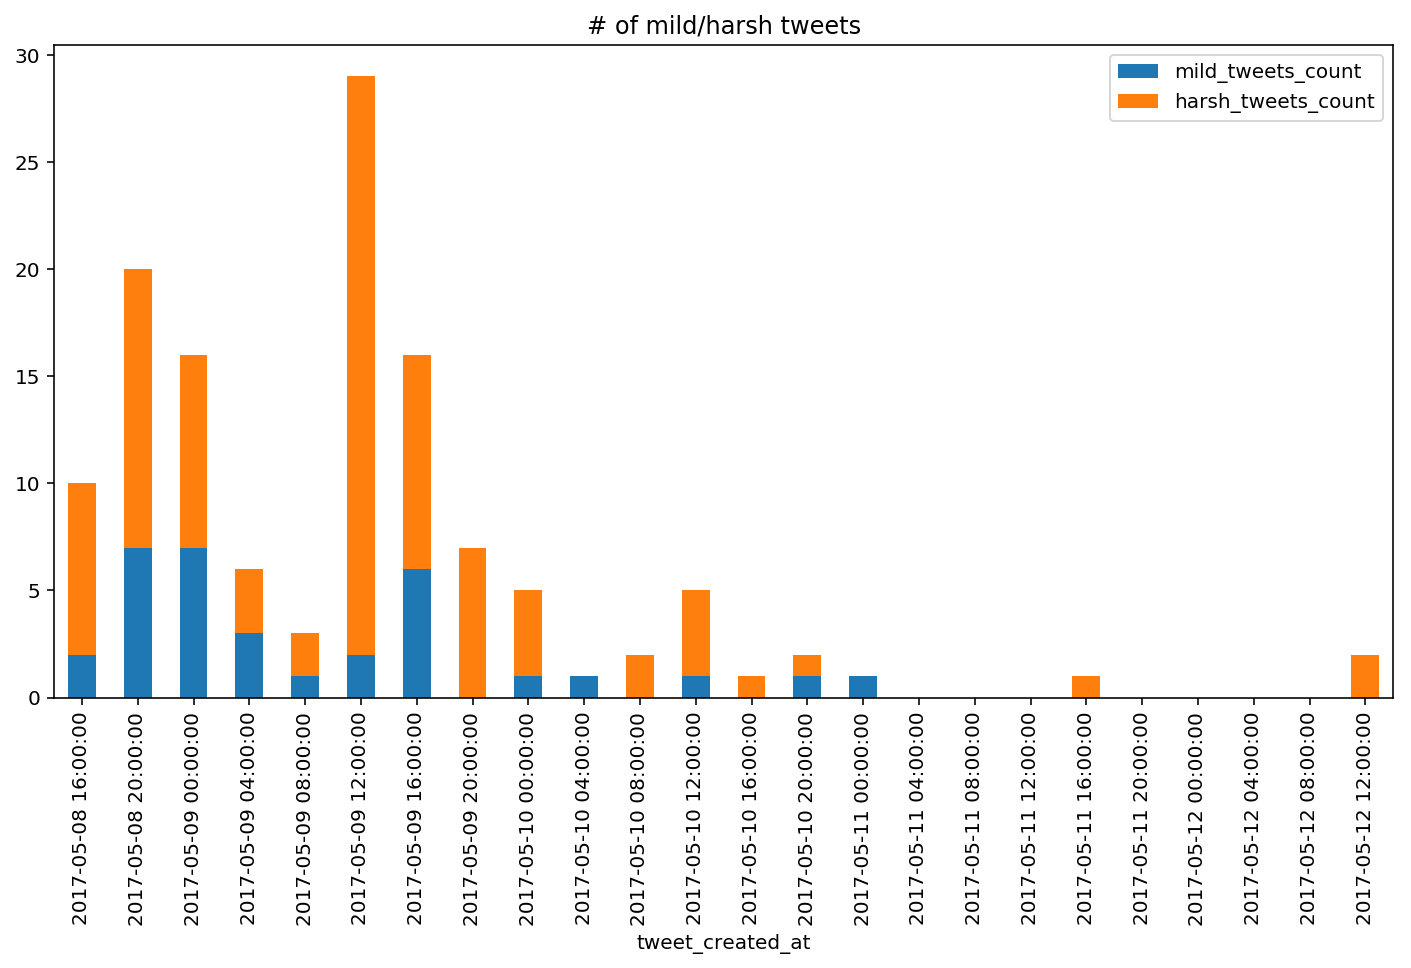

In [8]:
if 1 == 1:
    tweets_count.plot(kind="bar", figsize=(12,6), title='# of mild/harsh tweets', stacked=True)

### Plot use R ggplot2

In [9]:
"""
Prepare df data
"""
if 1 == 1:
    '''
    Read in all tweets related to the 'social_capital_ceo_palihapitiya_watson_joke' news
    '''
    target_tweets_df = pd.read_csv(filepath_or_buffer=palihapitiya_watson_joke_tweets_file,
                               sep='\t',
                               index_col=0,
                               parse_dates=['tweet_created_at'],
                               quoting=csv.QUOTE_MINIMAL)
    '''
    Read in manually tagged information for all tweets just loaded 
    '''
    target_tweets_tag_df = pd.read_csv(filepath_or_buffer=palihapitiya_watson_joke_tweets_tag_file,
                                       sep='\t',
                                       index_col=0)
    
    '''
    Join dfs and set index
    '''
    test_tweets_df = target_tweets_df.join(target_tweets_tag_df)
    test_tweets_df['tweet_index'] = test_tweets_df.index
    test_tweets_df = test_tweets_df.set_index('tweet_created_at')
    
    '''
    Bin mild/harsh tweets by 4H period and count numbers
    '''
    mild_tweets_df = test_tweets_df[(test_tweets_df['tweet_news'] == 1) & (test_tweets_df['tweet_sentiment'] == 2)]
    harsh_tweets_df = test_tweets_df[(test_tweets_df['tweet_news'] == 1) & (test_tweets_df['tweet_sentiment'] == 3)]
    
    mild_tweets_bin_count = mild_tweets_df['tweet_index'].resample('4H', label='start', loffset='2H 1S').count().rename('mild_tweets_count')
    harsh_tweets_bin_count = harsh_tweets_df['tweet_index'].resample('4H', label='start', loffset='2H 1S').count().rename('harsh_tweets_count')
    
    tweets_count = pd.concat([mild_tweets_bin_count, harsh_tweets_bin_count], axis=1)
    
    '''
    Misc operations
    '''
    tweets_count = tweets_count.fillna(0)
    
    tweets_count['mild_tweets_count'] = tweets_count['mild_tweets_count'].astype(int)
    
    tweets_count['harsh_mild_diff'] = tweets_count['harsh_tweets_count'] - tweets_count['mild_tweets_count']
    
    tweets_count['mild_tweets_count_neg'] = - tweets_count['mild_tweets_count']
    
    tweets_count.reset_index(drop=False, inplace=True)
    
    tweets_r_df = tweets_count

In [10]:
%%R -i tweets_r_df

# 
# Prepare data
# 

# cast data types
tweets_r_df$tweet_created_at <- as.POSIXct(tweets_r_df$tweet_created_at)
# # the order of levels determines the order of layers in ggplot
# tweets_r_df$tweet_sentiment <- factor(tweets_r_df$tweet_sentiment, levels=c(3, 2, 1))

#
# Plot and tweak histogram
#

# initialize new plot
# cols <- c('Harsh'='red', 'Mild'='blue', 'diff_line'='black')
plt <- ggplot(data=tweets_r_df, aes(x=tweet_created_at)) + 
    # layer of geom_bar for harsh tweets
    geom_bar(aes(y=harsh_tweets_count, , fill = 'Harsh'), stat = 'identity', alpha = 0.75) + 

    # layer of geom_bar for mild tweets
    geom_bar(aes(y=mild_tweets_count_neg, fill = 'Mild'), stat = 'identity', alpha = 0.65) + 

    # layer of geom_bar for harsh tweets
    # NOTE: tweak x-axis values to match bar plots above (minus 2 hrs)
    geom_step(aes(x=(tweet_created_at - 2*60*60), y=harsh_mild_diff), stat = 'identity', direction = 'hv', linetype='dashed') + 
    
    # x-axis and y-axis
    scale_x_datetime(name='Time',
                     date_labels = "%b %d %I%p",
                     date_breaks = "4 hour",
                     expand=c(0, 0),
                     limits = c(as.POSIXct(strptime('2017-05-08 12:00:00', format = "%Y-%m-%d %H:%M:%S")), 
                                as.POSIXct(strptime('2017-05-10 19:00:00', format = "%Y-%m-%d %H:%M:%S")))) + 
    
    scale_y_continuous(name='Number of users', 
                       breaks = c(-10, -5, 0, 5, 10, 15, 20, 25),
                       labels = c('10', '5', '0', '5', '10', '15', '20', '25'),
                       limits = c(-15, 30)) + 

    # legend
    scale_fill_manual(name="Sentiment Intensity",
                      values=c('Harsh'='red', 'Mild'='blue')) + 

    # theme
    theme(panel.background = element_blank(),
          axis.line = element_line(color='black'),
          panel.grid.major.y = element_line(color='grey80'),
          panel.grid.major.x = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_text(angle = 90),
          legend.position = 'top')

#
# Output figure
#
ggsave('./fig/ibm_joke_or_not.png', plt, height=5, width=5, dpi=200)